In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
EXPERIMENT_NAME = "runs_multi"

COMPUTE_LIKELIHOODS = True

# FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
# FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
# os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [15]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_multi
Available domains: ['re2', 'clevr', 'logo']


## Runtime metrics

In [16]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

domain  experiment_type                     model_type           model_fn                      task_split
clevr   baseline_dreamcoder                 amortized_synthesis  infer_programs_for_tasks      test           627.410529
                                                                                               train          626.392419
                                                                 optimize_model_for_frontiers  train          639.112597
                                            grammar              infer_programs_for_tasks      train          602.131269
        gpt_solver                          llm_solver           infer_programs_for_tasks      test           754.704399
                                                                                               train          717.473114
        gpt_solver_stitch_namer             library_namer        generate_library_names        train           17.619742
                                            llm

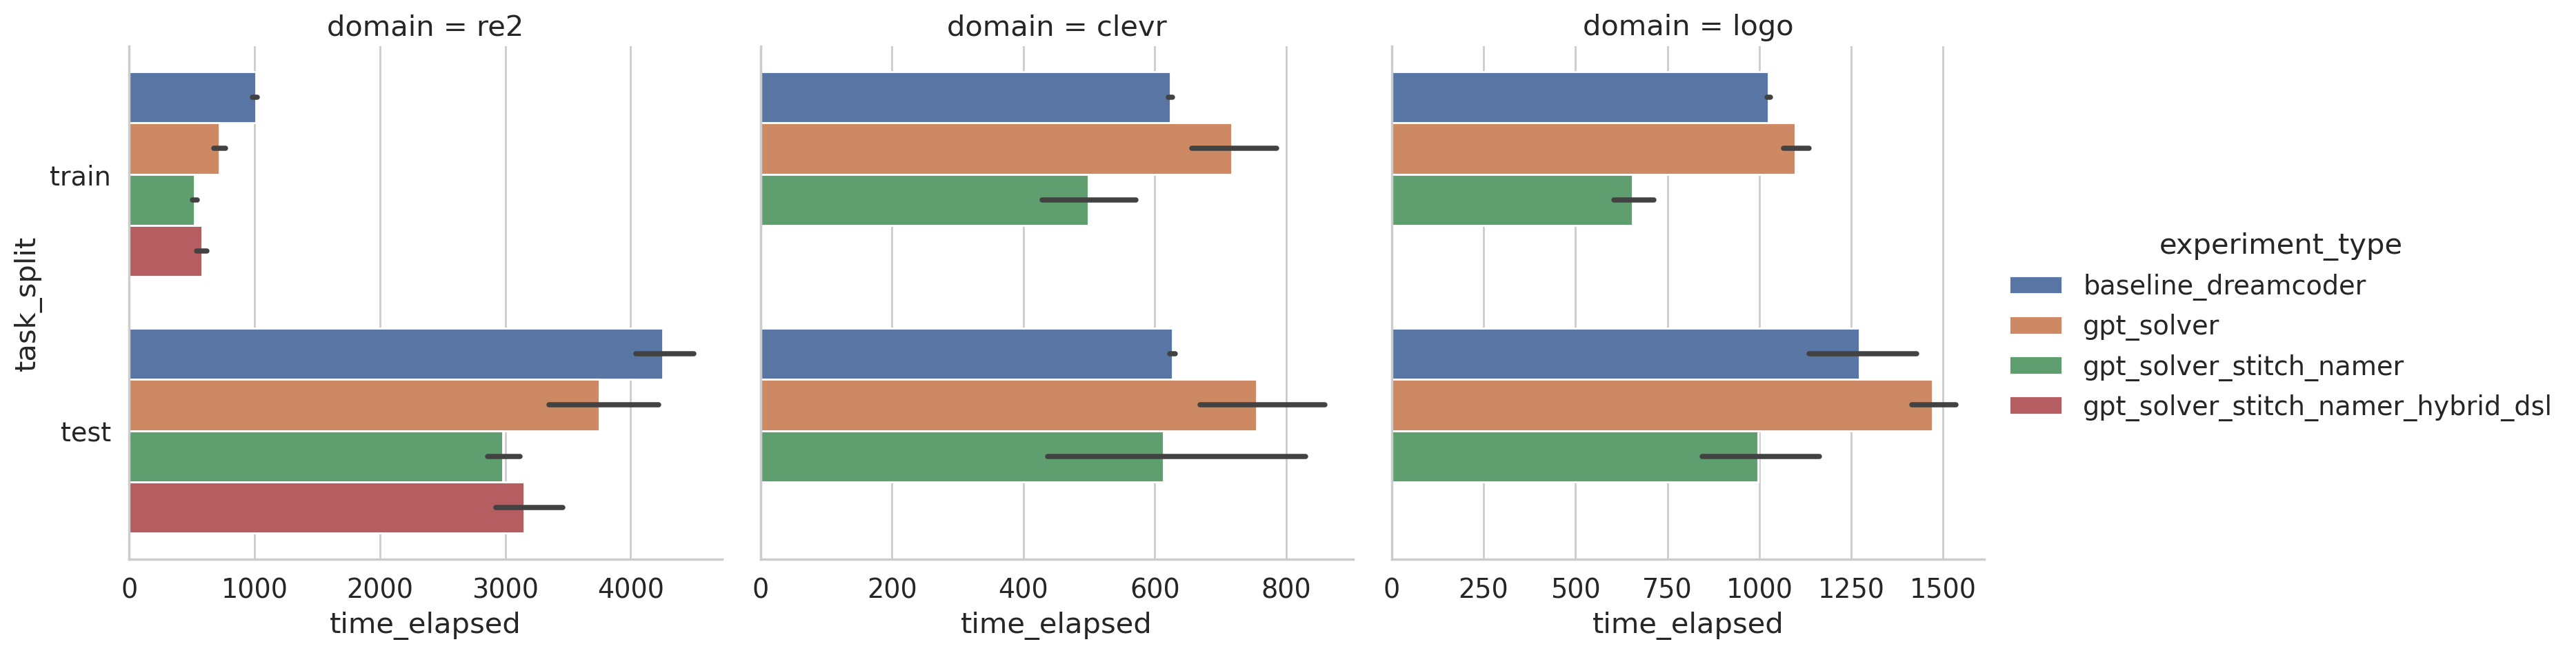

In [17]:
sns.catplot(kind="bar", col="domain", sharex=False, data=df_runtime.query("model_fn == 'infer_programs_for_tasks'"), y="task_split", x="time_elapsed", hue="experiment_type")

# Analysis 1: Tasks solved over time

In [18]:
analyzer.get_synthesis_results()

,request,task,programs,best_search_time,split,solved,seed,iteration,experiment_type,domain
0,"{'constructor': '->', 'arguments': [{'construc...",re2_train_0_if_the_word_ends_with_any_letter_a...,[],NaN,train,False,111,0,baseline_dreamcoder,re2
1,"{'constructor': '->', 'arguments': [{'construc...",re2_train_1_if_there_is_consonant_replace_that...,[],NaN,train,False,111,0,baseline_dreamcoder,re2
2,"{'constructor': '->', 'arguments': [{'construc...",re2_train_2_if_the_word_ends_with_consonant_s_...,[],NaN,train,False,111,0,baseline_dreamcoder,re2
3,"{'constructor': '->', 'arguments': [{'construc...",re2_train_3_if_there_is_d_replace_that_with_y,[],NaN,train,False,111,0,baseline_dreamcoder,re2
4,"{'constructor': '->', 'arguments': [{'construc...",re2_train_4_if_there_is_b_add_k_before_that,[],NaN,train,False,111,0,baseline_dreamcoder,re2
...,...,...,...,...,...,...,...,...,...,...
155305,"{'constructor': '->', 'arguments': [{'construc...",7 sided snowflake with a short space and a sho...,[],NaN,test,False,333,9,gpt_solver_stitch_namer,logo
155306,"{'constructor': '->', 'arguments': [{'construc...",3 sided snowflake with a short space and a sho...,[],NaN,test,False,333,9,gpt_solver_stitch_namer,logo
155307,"{'constructor': '->', 'arguments': [{'construc...",7 sided snowflake with a short space and a sho...,[],NaN,test,False,333,9,gpt_solver_stitch_namer,logo
155308,"{'constructor': '->', 'arguments': [{'construc...",6 sided snowflake with a short space and a sho...,[],NaN,test,False,333,9,gpt_solver_stitch_namer,logo


### Tasks solved vs. LAPS iteration

In [23]:
df_results = analyzer.get_synthesis_summary()
df_results

,domain,experiment_type,seed,iteration,split,n_solved,percent_solved
0,clevr,baseline_dreamcoder,111,0,test,43,0.417476
1,clevr,baseline_dreamcoder,111,0,train,41,0.214660
2,clevr,baseline_dreamcoder,111,1,train,97,0.507853
3,clevr,baseline_dreamcoder,111,2,train,127,0.664921
4,clevr,baseline_dreamcoder,111,3,test,86,0.834951
...,...,...,...,...,...,...,...
512,re2,gpt_solver_stitch_namer_hybrid_dsl,222,2,train,116,0.236253
513,re2,gpt_solver_stitch_namer_hybrid_dsl,222,3,test,244,0.488000
514,re2,gpt_solver_stitch_namer_hybrid_dsl,222,3,train,153,0.311609
515,re2,gpt_solver_stitch_namer_hybrid_dsl,222,4,train,186,0.378819


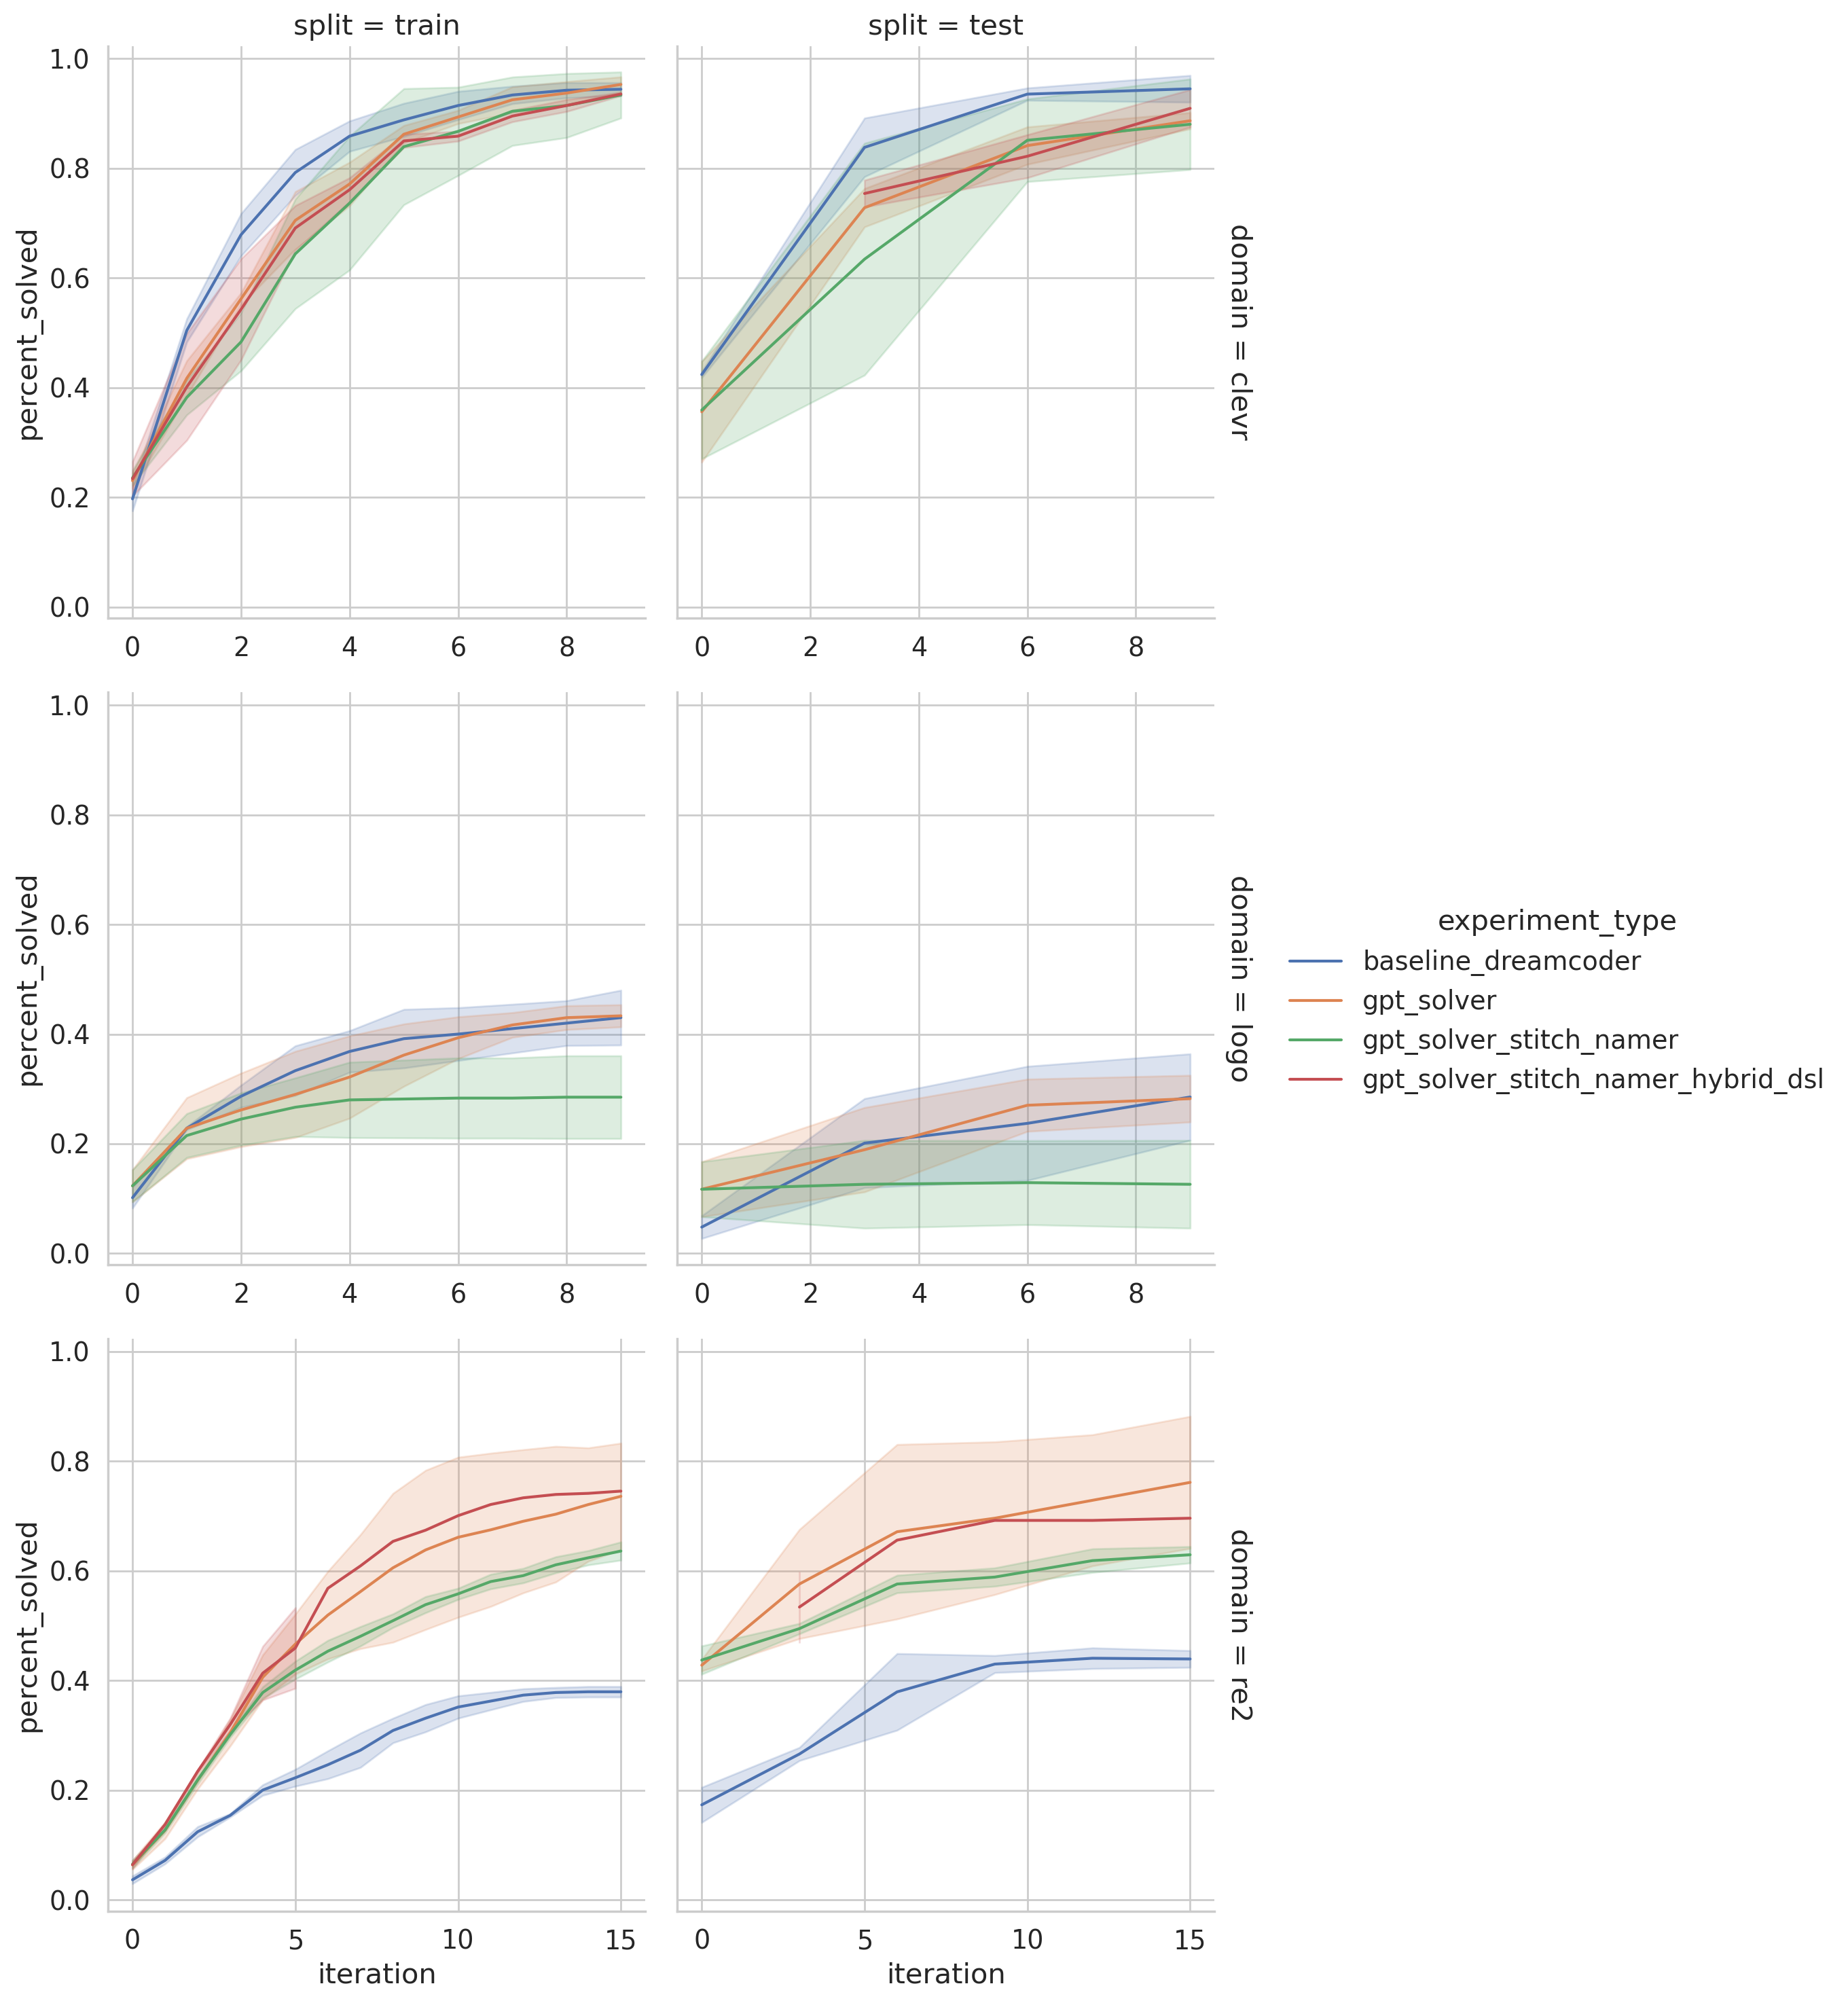

In [24]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    # style="seed",
    markers=True,
    errorbar="sd", # se
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

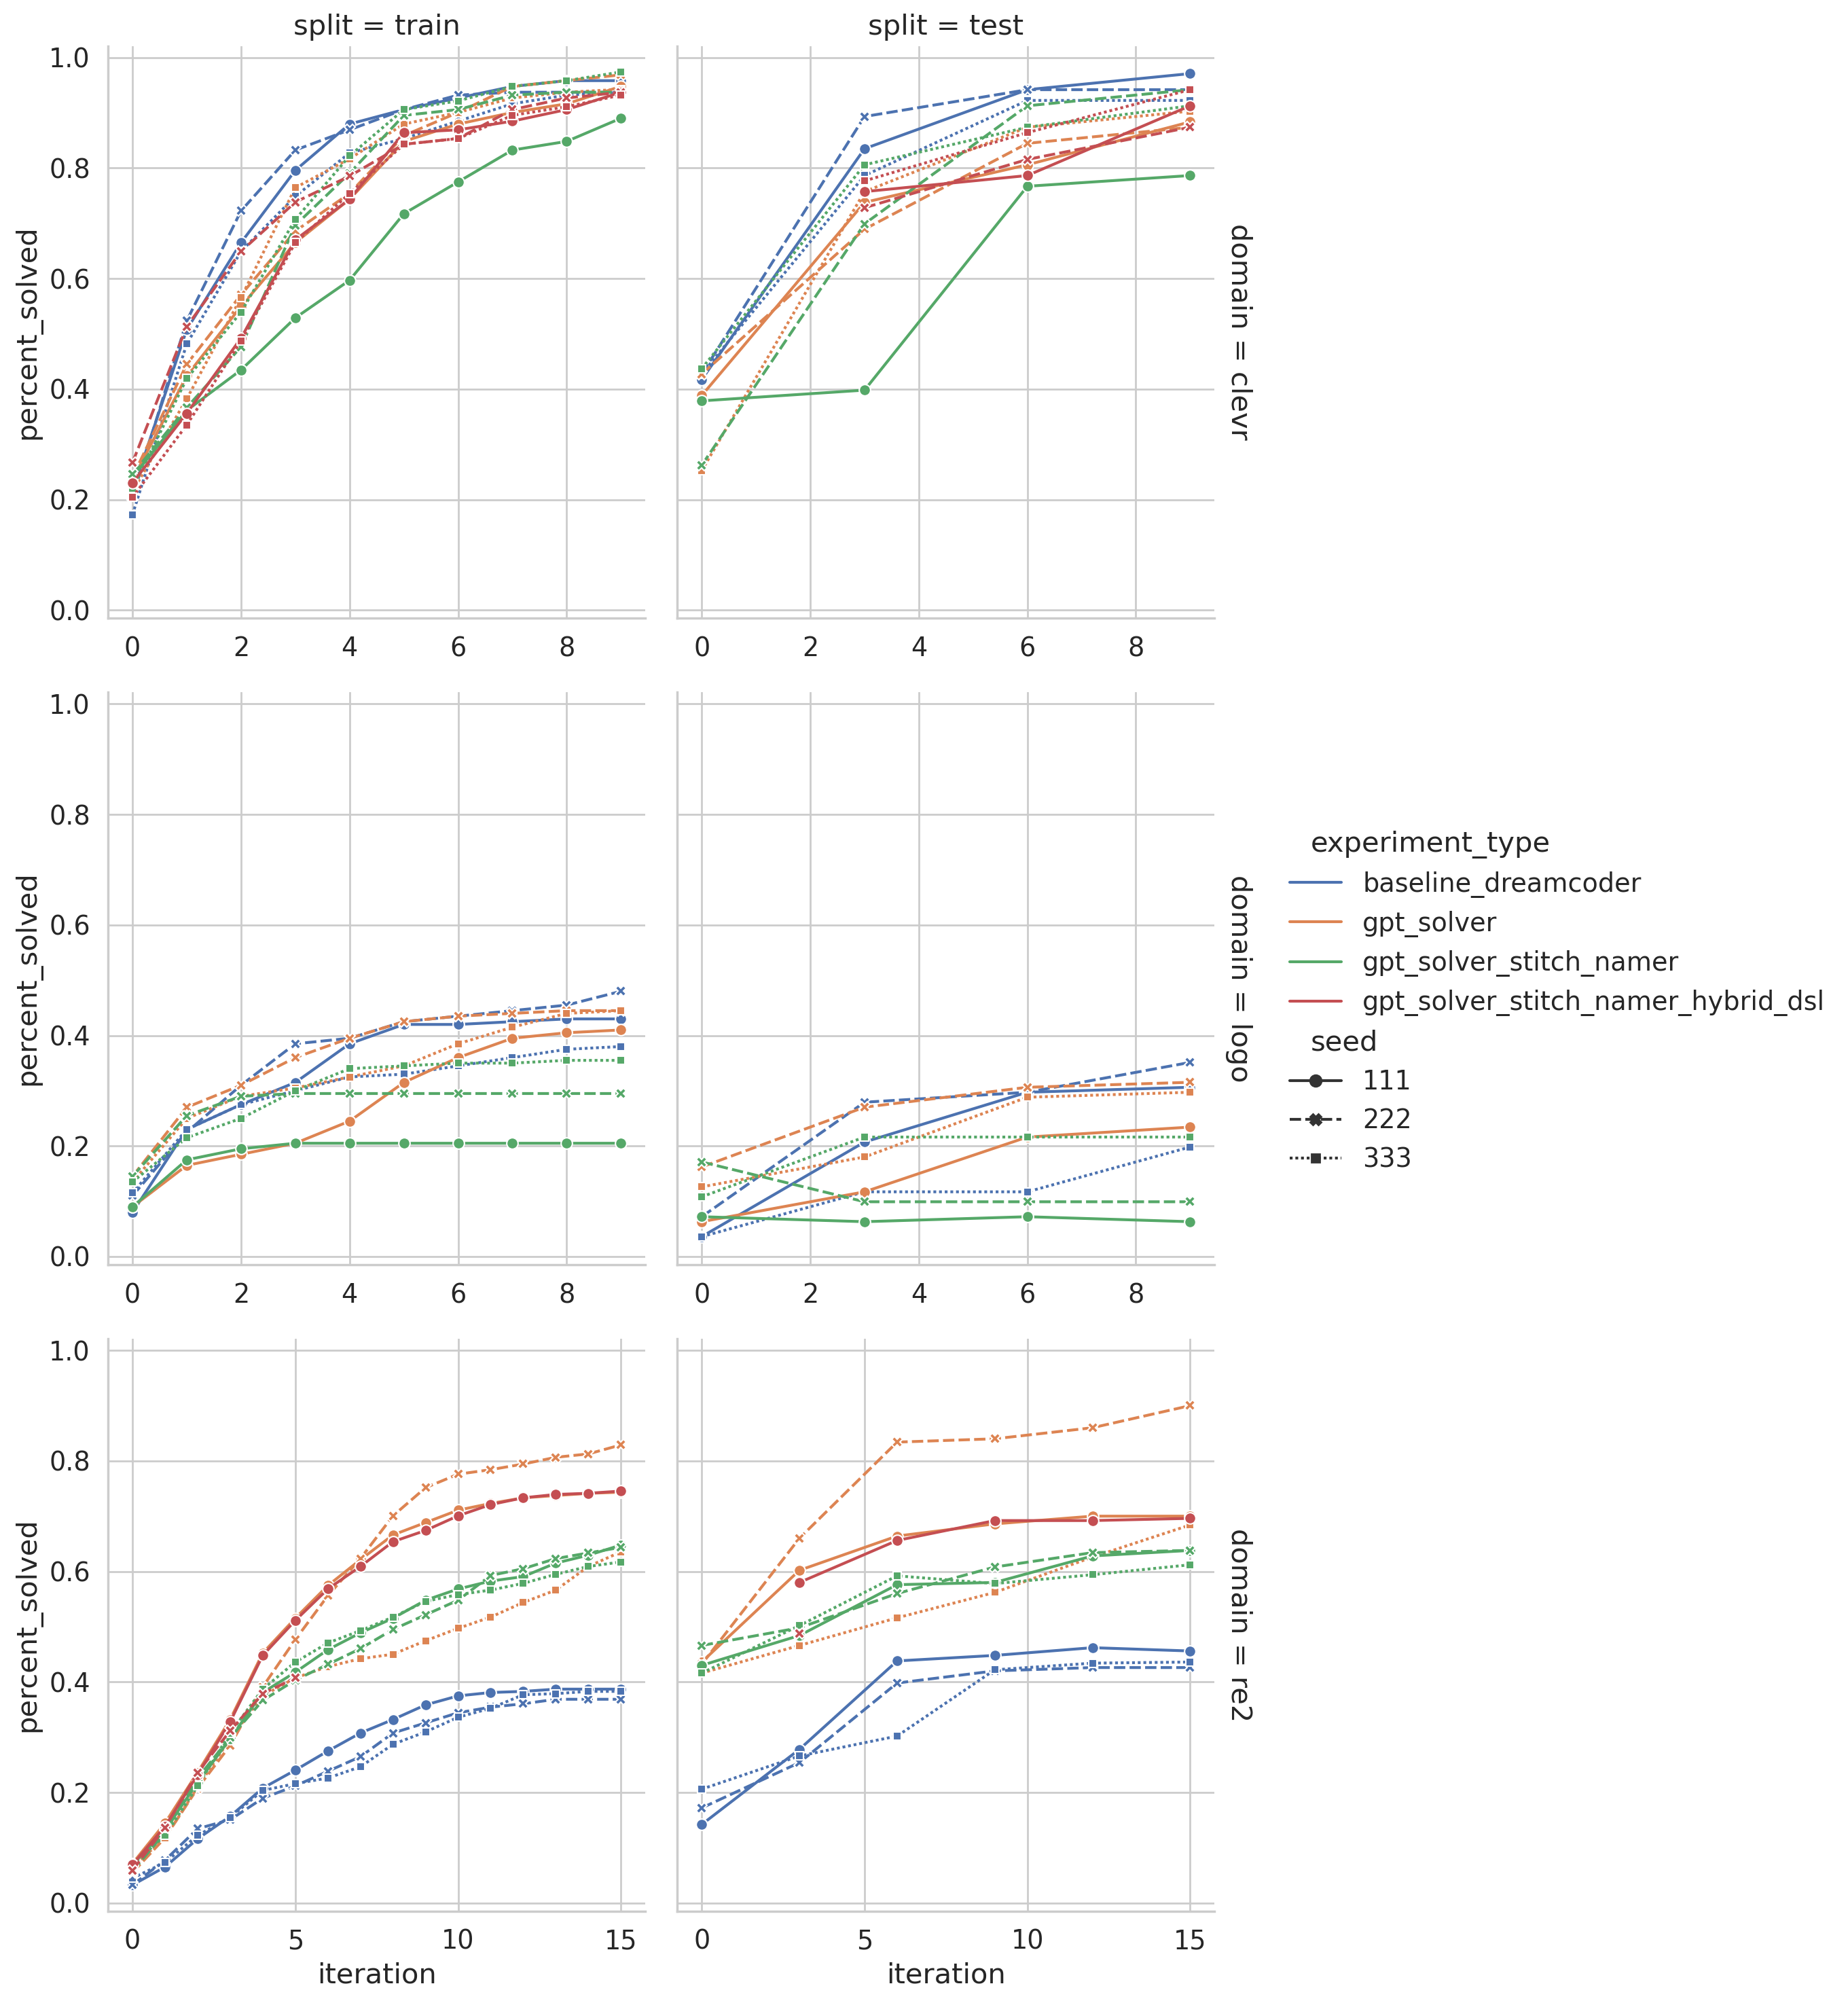

In [25]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    style="seed",
    markers=True,
    # errorbar="se",
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

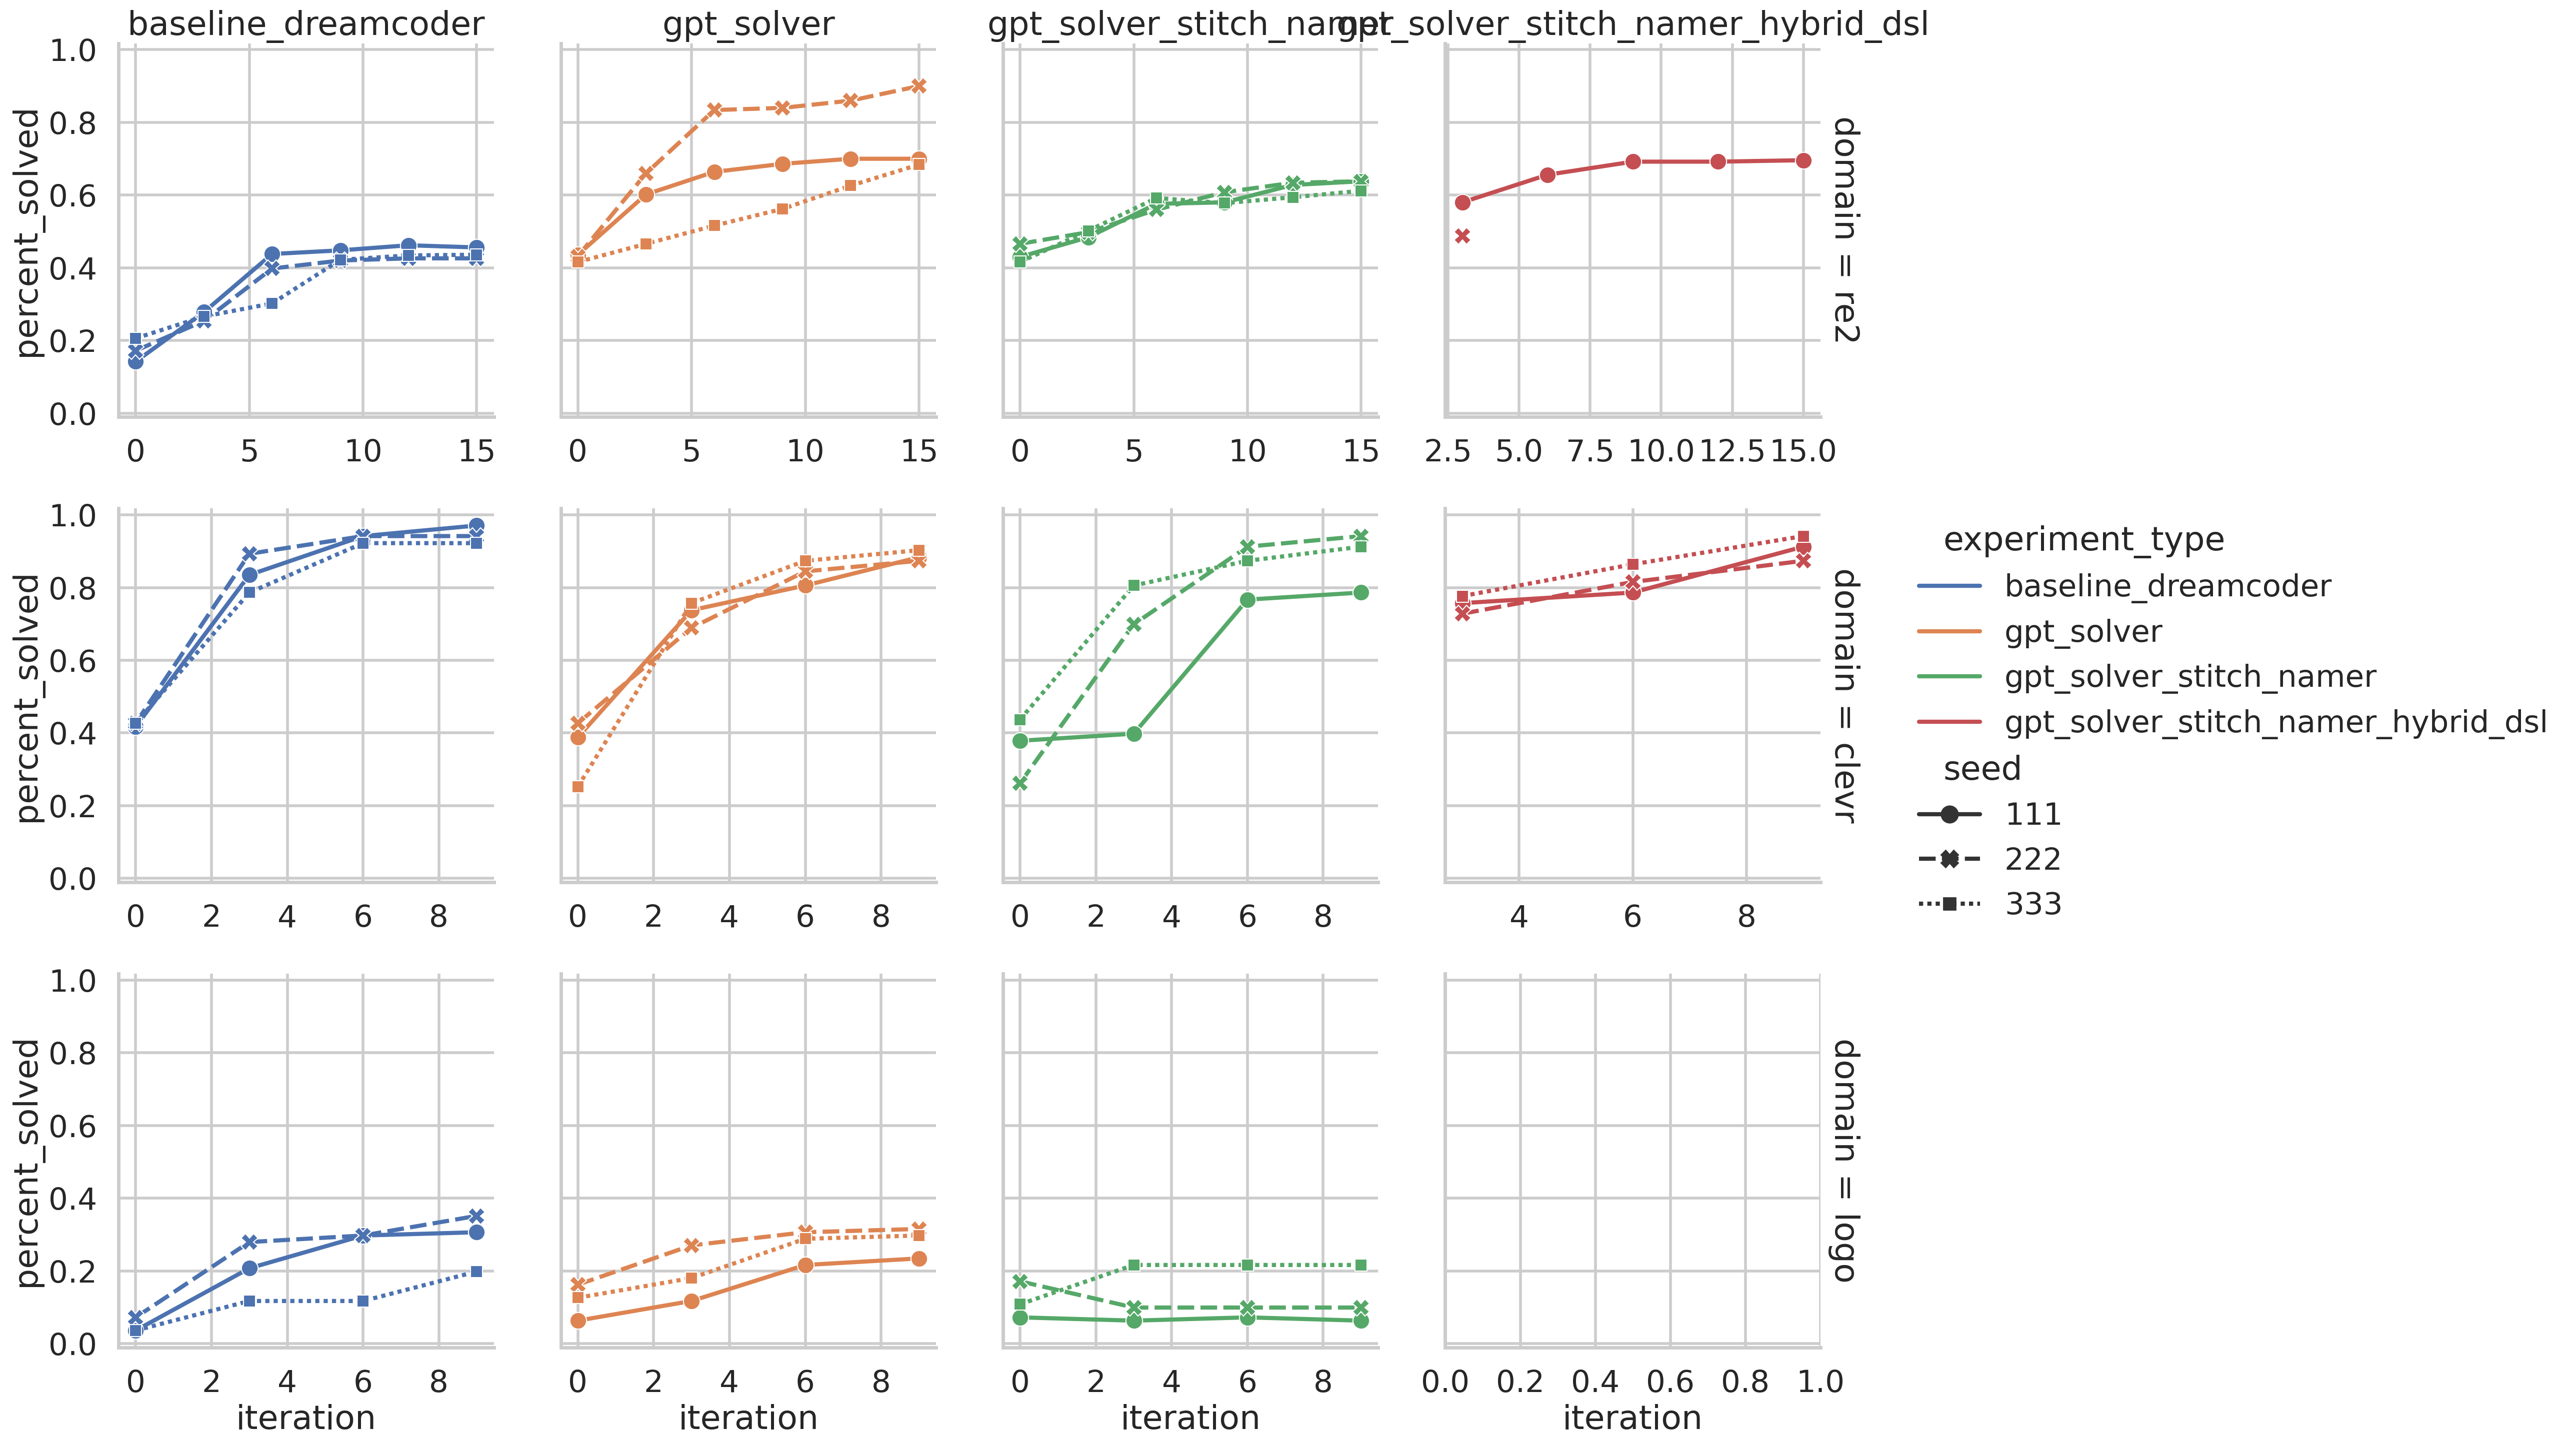

In [26]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results.query("split == 'test'"),
        kind="line",
        row="domain",
        col="experiment_type",
        x="iteration", 
        y="percent_solved", 
        hue="experiment_type",
        style="seed",
        markers=True,
        errorbar="se",
        # col_order=["train", "test"],
        row_order = ["re2", "clevr", "logo"],
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])

# plt.suptitle(f"{DOMAIN}", y=1.025)

In [27]:
for subplot in g.axes[0]:
    print(subplot.title.get_text().split(" = "))

['baseline_dreamcoder']
['gpt_solver']
['gpt_solver_stitch_namer']
['gpt_solver_stitch_namer_hybrid_dsl']


In [16]:
str()

''